# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='fivethirtyeight')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [5]:
##visualize Pipeline
from sklearn import set_config
set_config(display="diagram")

# Loading & Inspecting Data

In [6]:
data = pd.read_csv('Walmart.csv')

In [7]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
# Information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [9]:
pd.options.display.float_format = '{:,.0f}'.format

In [10]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,"1,643,691",0,42,3,211,8
1,1,12-02-2010,"1,641,957",1,39,3,211,8
2,1,19-02-2010,"1,611,968",0,40,3,211,8
3,1,26-02-2010,"1,409,728",0,47,3,211,8
4,1,05-03-2010,"1,554,807",0,46,3,211,8
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,"713,174",0,65,4,192,9
6431,45,05-10-2012,"733,455",0,65,4,192,9
6432,45,12-10-2012,"734,464",0,54,4,192,9
6433,45,19-10-2012,"718,126",0,56,4,192,9


In [11]:
# data distribution
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,"6,435","6,435","6,435","6,435","6,435","6,435","6,435"
mean,23,"1,046,965",0,61,3,172,8
std,13,"564,367",0,18,0,39,2
min,1,"209,986",0,-2,2,126,4
25%,12,"553,350",0,47,3,132,7
50%,23,"960,746",0,63,3,183,8
75%,34,"1,420,159",0,75,4,213,9
max,45,"3,818,686",1,100,4,227,14


# Data Preprocessing

## 1. Renaming Columns and changing Date column into Date format

In [12]:
data.columns  = data.columns.str.lower()

data.rename({'holiday_flag': 'is_holiday'}, axis = 1, inplace = True)

# correct data format of the 'date' column
data['date'] = pd.to_datetime(data['date'], format = "%d-%m-%Y")

In [13]:
data

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment
0,1,2010-02-05,"1,643,691",0,42,3,211,8
1,1,2010-02-12,"1,641,957",1,39,3,211,8
2,1,2010-02-19,"1,611,968",0,40,3,211,8
3,1,2010-02-26,"1,409,728",0,47,3,211,8
4,1,2010-03-05,"1,554,807",0,46,3,211,8
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,174",0,65,4,192,9
6431,45,2012-10-05,"733,455",0,65,4,192,9
6432,45,2012-10-12,"734,464",0,54,4,192,9
6433,45,2012-10-19,"718,126",0,56,4,192,9


## 2. Checking for Missing Values

In [14]:
data.isnull().sum()

store           0
date            0
weekly_sales    0
is_holiday      0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

**Conclusion**
- The dataset doesn't have any missing values

## 3. Duplicate Values

In [15]:
data.duplicated().sum()

0

**Conclusion:**

- The dataset doesn't have any duplicate values

## 4. Feature Engineering

In [16]:
# Create a new column "year" containing the year
data['year'] = data['date'].dt.year

# Create a new column "month" containing the month number
data['month'] = data['date'].dt.month

# Create a new column "month_name" containing the month names
data['month_name'] = data['date'].dt.month_name()

# Create a new column "week" containing the week number
data['week'] = data['date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
data['day_name'] = data['date'].dt.day_name()

# Create a new column "quarter" containing the season number
data['quarter'] = data['date'].dt.quarter

In [17]:
#Function to retrieve the season.
def get_season(quarter):

    if quarter == 1:
        return 'Winter'
    elif quarter == 2:
        return 'Spring'
    elif quarter == 3:
        return 'Summer'
    else:
        return 'Autumn'

In [18]:
# Create a new column "season" containing the season
data['season'] = data['quarter'].apply(get_season)

In [19]:
data

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,month,month_name,week,day_name,quarter,season
0,1,2010-02-05,"1,643,691",0,42,3,211,8,2010,2,February,5,Friday,1,Winter
1,1,2010-02-12,"1,641,957",1,39,3,211,8,2010,2,February,6,Friday,1,Winter
2,1,2010-02-19,"1,611,968",0,40,3,211,8,2010,2,February,7,Friday,1,Winter
3,1,2010-02-26,"1,409,728",0,47,3,211,8,2010,2,February,8,Friday,1,Winter
4,1,2010-03-05,"1,554,807",0,46,3,211,8,2010,3,March,9,Friday,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,174",0,65,4,192,9,2012,9,September,39,Friday,3,Summer
6431,45,2012-10-05,"733,455",0,65,4,192,9,2012,10,October,40,Friday,4,Autumn
6432,45,2012-10-12,"734,464",0,54,4,192,9,2012,10,October,41,Friday,4,Autumn
6433,45,2012-10-19,"718,126",0,56,4,192,9,2012,10,October,42,Friday,4,Autumn


# Exploratory Data Analysis (EDA)

## 1. Univariate Analysis

### A. Numerical Data

In [20]:
numerical_columns = data.select_dtypes(include=['number'])

In [21]:
numerical_columns

,store,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,month,week,quarter
0,1,"1,643,691",0,42,3,211,8,2010,2,5,1
1,1,"1,641,957",1,39,3,211,8,2010,2,6,1
2,1,"1,611,968",0,40,3,211,8,2010,2,7,1
3,1,"1,409,728",0,47,3,211,8,2010,2,8,1
4,1,"1,554,807",0,46,3,211,8,2010,3,9,1
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,"713,174",0,65,4,192,9,2012,9,39,3
6431,45,"733,455",0,65,4,192,9,2012,10,40,4
6432,45,"734,464",0,54,4,192,9,2012,10,41,4
6433,45,"718,126",0,56,4,192,9,2012,10,42,4


In [22]:
#Removing 'is_holiday','year','month','week','quarter'
numerical_columns = numerical_columns.drop(columns=['is_holiday','year','month','week','quarter'])

In [23]:
numerical_columns

,store,weekly_sales,temperature,fuel_price,cpi,unemployment
0,1,"1,643,691",42,3,211,8
1,1,"1,641,957",39,3,211,8
2,1,"1,611,968",40,3,211,8
3,1,"1,409,728",47,3,211,8
4,1,"1,554,807",46,3,211,8
...,...,...,...,...,...,...
6430,45,"713,174",65,4,192,9
6431,45,"733,455",65,4,192,9
6432,45,"734,464",54,4,192,9
6433,45,"718,126",56,4,192,9


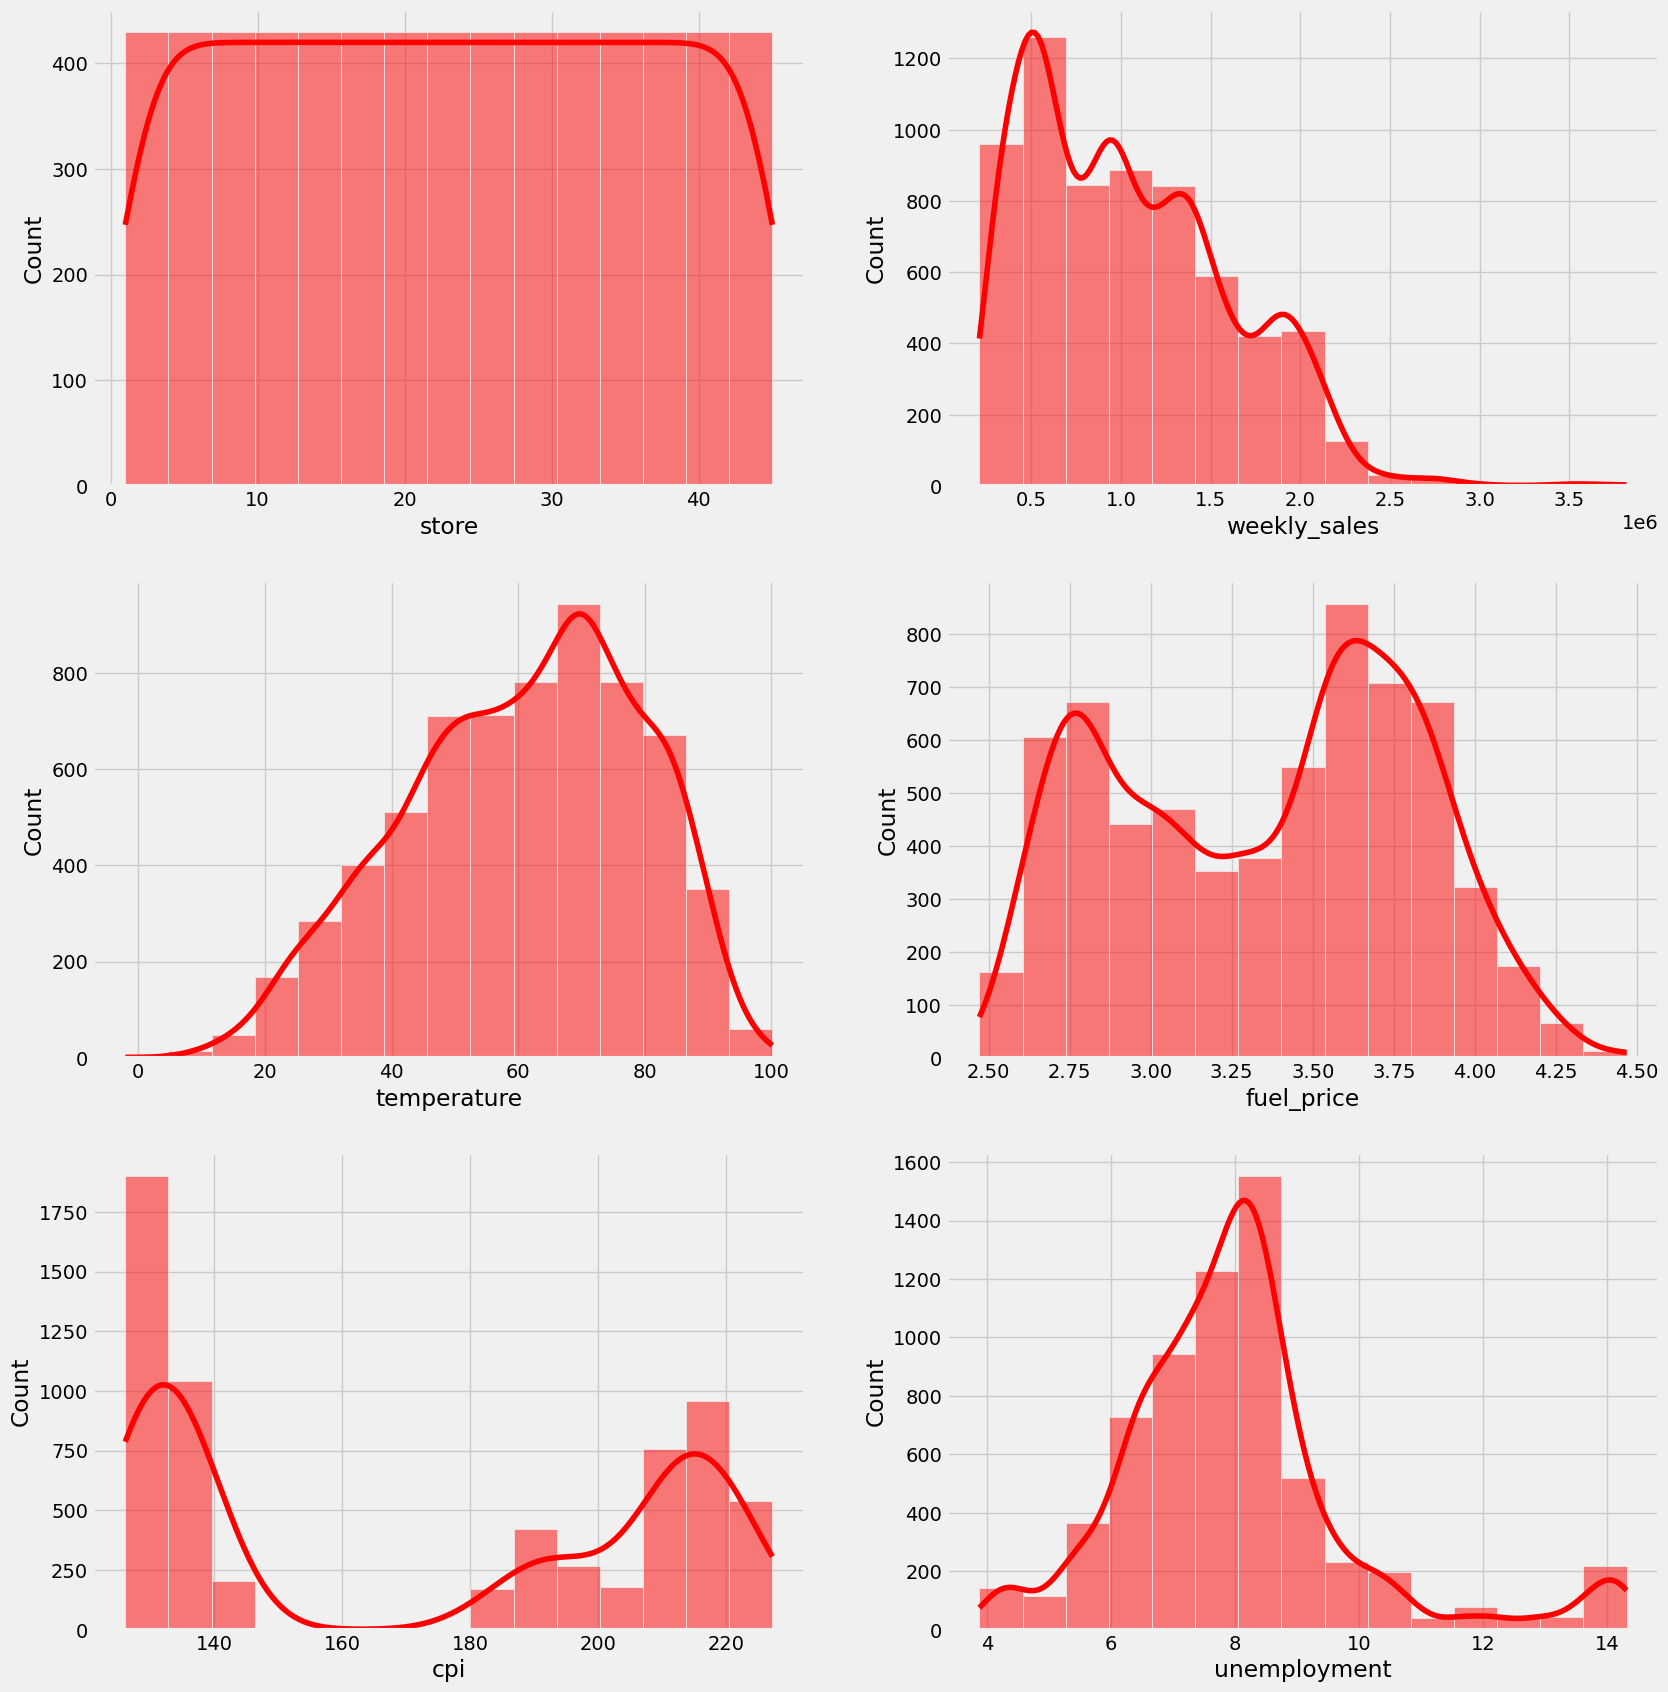

In [24]:
#Plotting histogram with KDE to check the distribution.
plt.figure(figsize=(18, 20))
for i,col in enumerate(numerical_columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'r')
plt.show()

**Conclusion:**

- Store is uniformly distributed.
- Weekly sales is right skew.
- Temperature and Unemployment is almost normally distributed.
- CPI and Fuel_Price have bimodal distribution.

### B. Categorical Data

#### is_holiday

<AxesSubplot: xlabel='is_holiday', ylabel='count'>

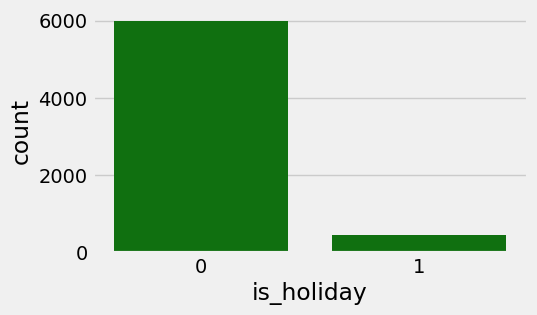

In [25]:
plt.figure(figsize=(5, 3))
sns.countplot(data = data, x = 'is_holiday',color='green')

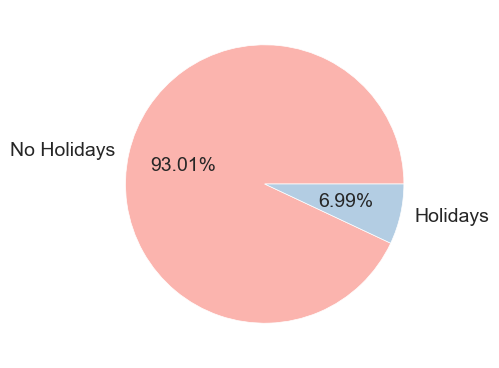

In [26]:
cmap = plt.get_cmap('Pastel1')
sns.set_style("whitegrid")
plt.figure(figsize=(4, 6))
plt.pie(data['is_holiday'].value_counts(),
          labels = ['No Holidays', 'Holidays'],
          autopct = '%1.2f%%',colors=cmap.colors)
plt.show()

**Conclusion:**

- Days of no holiday are the most frequent than days of holiday in the dataset with a percentage of 93 % and this is normal.

#### year

<AxesSubplot: xlabel='year', ylabel='count'>

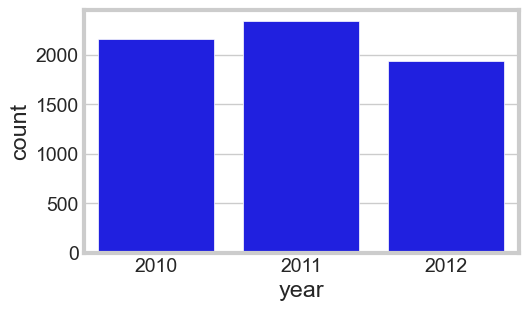

In [27]:
plt.figure(figsize=(5, 3))
sns.countplot(data = data, x = 'year',color='blue')

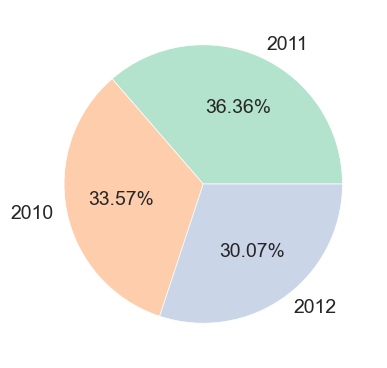

In [28]:
cmap = plt.get_cmap('Pastel2')
sns.set_style("whitegrid")
plt.figure(figsize=(4, 6))
plt.pie(data['year'].value_counts(),
          labels = data['year'].value_counts().index,
          autopct = '%1.2f%%',colors=cmap.colors)
plt.show()

**Conclusion:**

- 2011 is the most frequent in the dataset.

###  season

<AxesSubplot: xlabel='season', ylabel='count'>

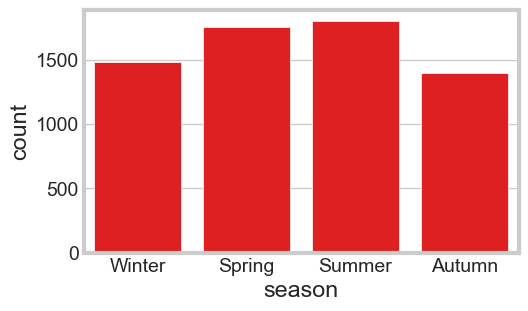

In [29]:
plt.figure(figsize=(5, 3))
sns.countplot(data = data, x = 'season',color='red')

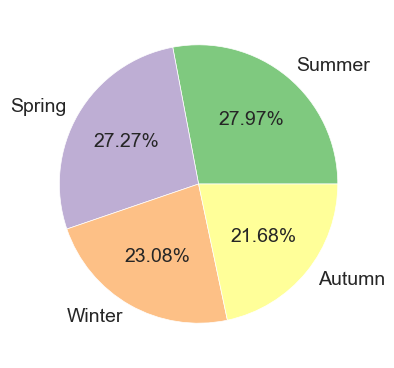

In [30]:
cmap = plt.get_cmap('Accent')
sns.set_style("whitegrid")
plt.figure(figsize=(4, 6))
plt.pie(data['season'].value_counts(),
          labels = data['season'].value_counts().index,
          autopct = '%1.2f%%',colors=cmap.colors)
plt.show()

**Conclusion:**

- Summer is the most frequent in the dataset.

###  month_name

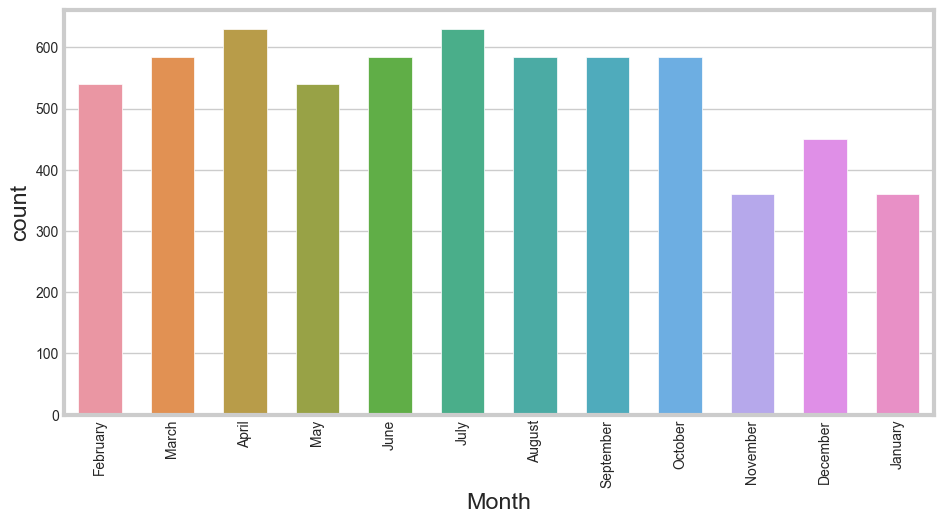

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(data = data, x = 'month_name',width=0.6)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Month')
plt.show()

**Conclusion:**

- April and July are the most frequent in the dataset because most of the weekly sales were recorded in these months.

#### Total sales in each year.

In [32]:
sales_by_year = data.groupby('year')['weekly_sales'].sum().sort_values(ascending = False).reset_index()

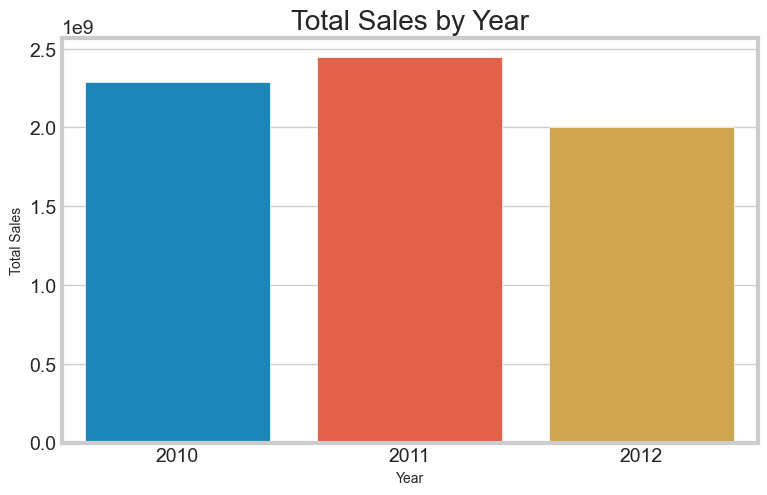

In [33]:
plt.figure(figsize = (8, 5))
sns.barplot(data = sales_by_year,x = 'year',y = 'weekly_sales')
#Adding Labels and title
plt.title('Total Sales by Year')
plt.xlabel('Year', size = 10)
plt.ylabel('Total Sales', size = 10)
plt.show()

**Conclusion:**

- 2011 has the highest sales.

#### Total sales in each season.

In [34]:
sales_by_season = data.groupby('season')['weekly_sales'].sum().sort_values(ascending = False).reset_index()

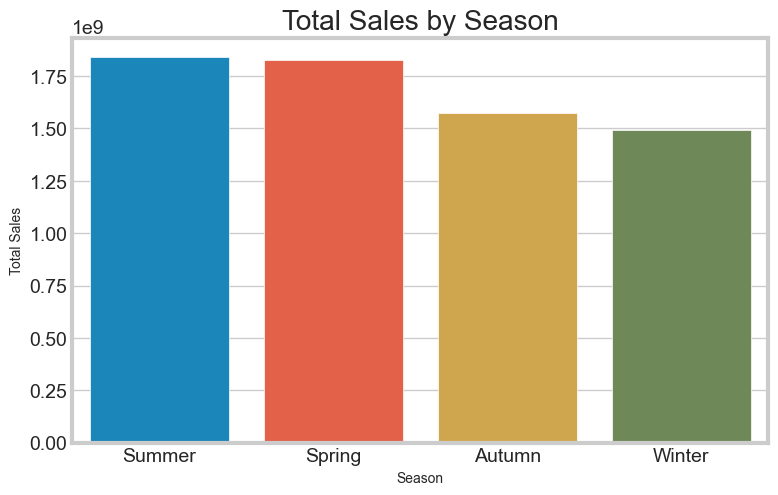

In [35]:
plt.figure(figsize = (8, 5))
sns.barplot(data = sales_by_season,x = 'season',y = 'weekly_sales')
#Adding Labels and title
plt.title('Total Sales by Season')
plt.xlabel('Season', size = 10)
plt.ylabel('Total Sales', size = 10)
plt.show()

**Conclusion**
- Sales are higher in Summer season.

### day_name

In [36]:
data['day_name'].value_counts()

Friday    6435
Name: day_name, dtype: int64

**Conclusion:**

- Each record has been recorded on Friday.

In [37]:
data

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,month,month_name,week,day_name,quarter,season
0,1,2010-02-05,"1,643,691",0,42,3,211,8,2010,2,February,5,Friday,1,Winter
1,1,2010-02-12,"1,641,957",1,39,3,211,8,2010,2,February,6,Friday,1,Winter
2,1,2010-02-19,"1,611,968",0,40,3,211,8,2010,2,February,7,Friday,1,Winter
3,1,2010-02-26,"1,409,728",0,47,3,211,8,2010,2,February,8,Friday,1,Winter
4,1,2010-03-05,"1,554,807",0,46,3,211,8,2010,3,March,9,Friday,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,174",0,65,4,192,9,2012,9,September,39,Friday,3,Summer
6431,45,2012-10-05,"733,455",0,65,4,192,9,2012,10,October,40,Friday,4,Autumn
6432,45,2012-10-12,"734,464",0,54,4,192,9,2012,10,October,41,Friday,4,Autumn
6433,45,2012-10-19,"718,126",0,56,4,192,9,2012,10,October,42,Friday,4,Autumn


## 2. Bi-variate Analysis

### Which store has the highest sales.

In [38]:
sales_by_store = data.groupby('store')['weekly_sales'].sum().sort_values(ascending = False)

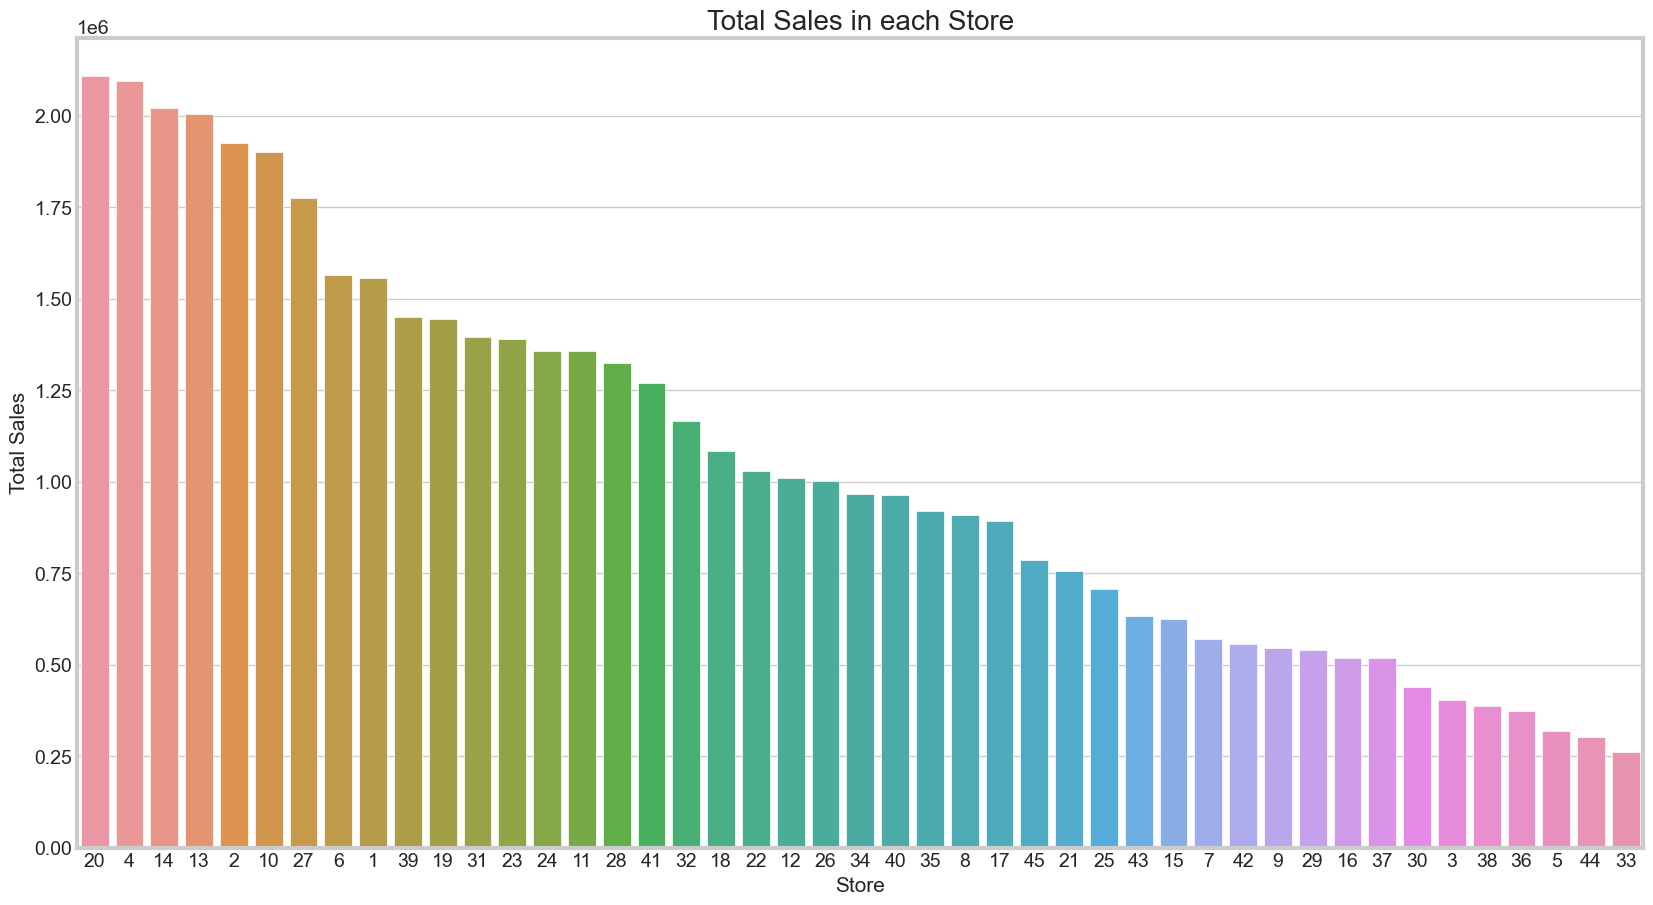

In [39]:
plt.figure(figsize = (18, 10))
sns.barplot(data = data,x = 'store',y = 'weekly_sales',order = sales_by_store.index,errorbar=('ci', False))
#Adding Labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

**Conclusion:**
- Store No. 20 has the highest sale.

####  Total sales on holidays and regular days.

In [40]:
sales_by_Holidays = data.groupby('is_holiday')['weekly_sales'].sum().reset_index()

In [41]:
sales_by_Holidays

,is_holiday,weekly_sales
0,0,"6,231,919,436"
1,1,"505,299,552"


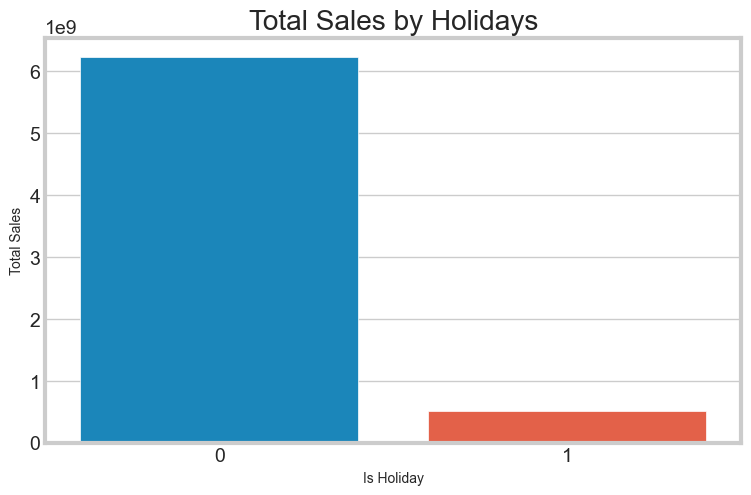

In [42]:
plt.figure(figsize = (8, 5))
sns.barplot(data = sales_by_Holidays,x = 'is_holiday',y = 'weekly_sales')
#Adding Labels and title
plt.title('Total Sales by Holidays')
plt.xlabel('Is Holiday', size = 10)
plt.ylabel('Total Sales', size = 10)
plt.show()

**Conclusion:**
- Total sales on holidays are lower than the normal days. Because no of Holidays are less as compare to the normal days.

### weekly_sales v/s temperature

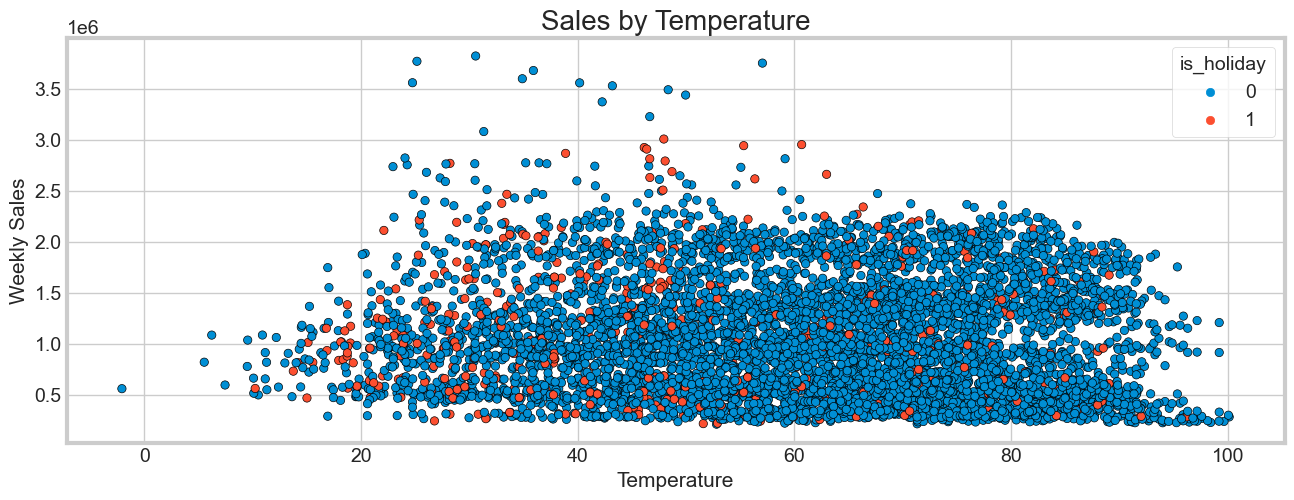

In [43]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,x = 'temperature',y = 'weekly_sales',hue='is_holiday',edgecolor = "black")
#Adding Labels and title
plt.title('Sales by Temperature', size = 20)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Weekly Sales', size = 15)
plt.show()

**Conclusion:**

- There is no effect of temperature in wekkly sales.

### weekly_sales v/s fuel_price

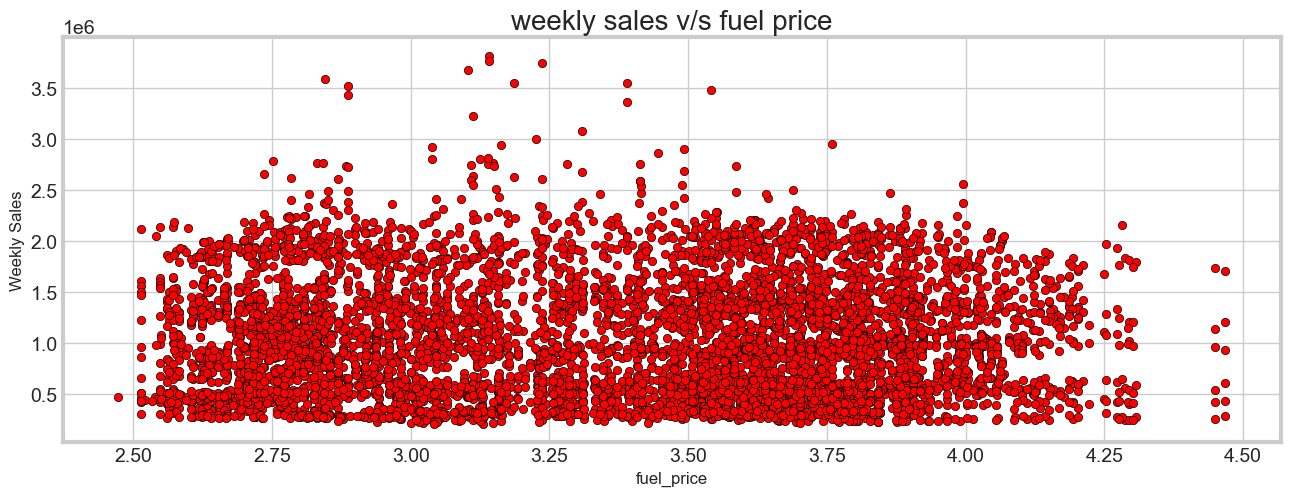

In [44]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,x = 'fuel_price',y = 'weekly_sales',edgecolor = "Black",color = 'red')
#Adding Labels and title
plt.title('weekly sales v/s fuel price', size = 20)
plt.xlabel('fuel_price', size = 12)
plt.ylabel('Weekly Sales', size = 12)
plt.show()

**Conclusion:**

- There is no effect of fuel_price in wekkly sales.

### weekly_sales v/s cpi  (Consumer Price Index)

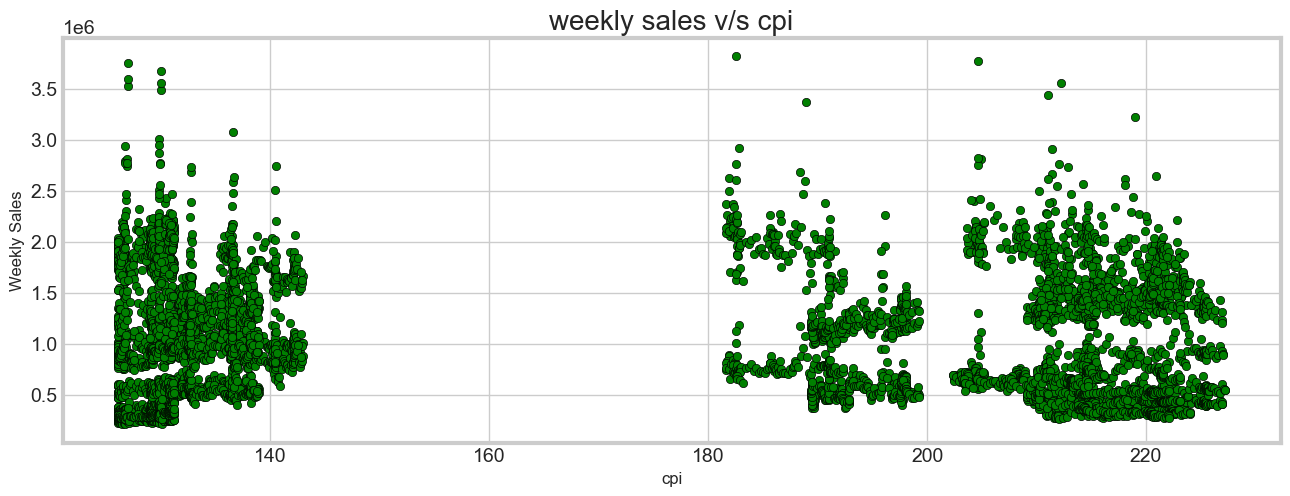

In [45]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,x = 'cpi',y = 'weekly_sales',edgecolor = "Black",color = 'green')
#Adding Labels and title
plt.title('weekly sales v/s cpi', size = 20)
plt.xlabel('cpi', size = 12)
plt.ylabel('Weekly Sales', size = 12)
plt.show()

**Conclusion:**

- There is no effect of CPI on Weekly sales. 
- However, we can cluster the customers into 3 part as per the above graph:
  - customers who pay from 120 to 150 (Middle-class customers).
  - customers who pay from 180 to 200 (High-class customers).
  - customers who pay more than 200.(Affluent customers)

### weekly_sales v/s unemployment

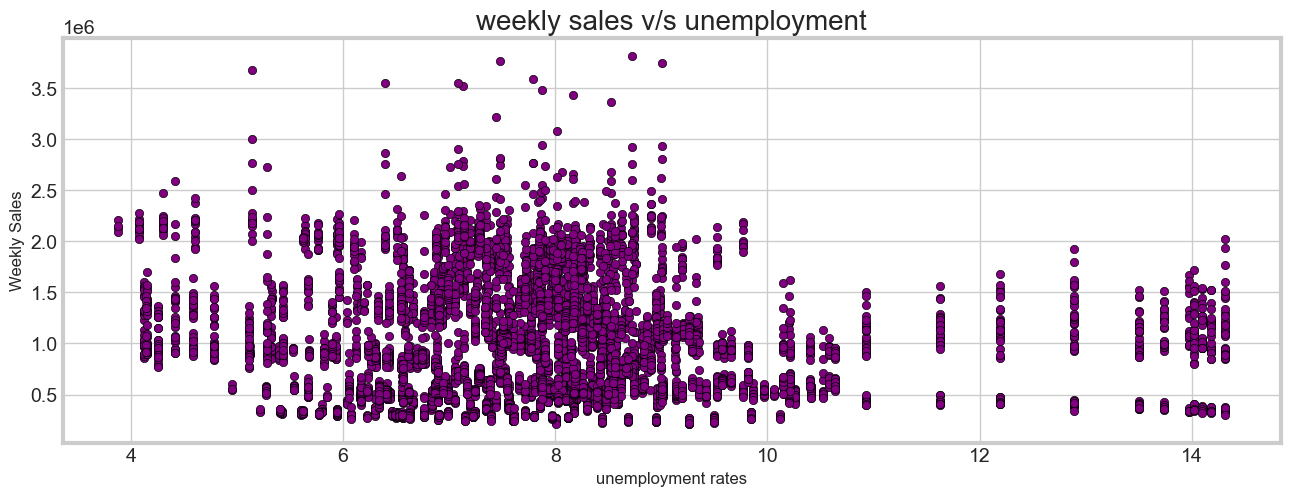

In [46]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,x = 'unemployment',y = 'weekly_sales',edgecolor = "black",color = 'purple')
#Adding Labels and title
plt.title('weekly sales v/s unemployment', size = 20)
plt.xlabel('unemployment rates', size = 12)
plt.ylabel('Weekly Sales', size = 12)
plt.show()

**Conclusion:**
- We can see the effects of unemployement rates on sales.
- As the unemployement rate increases the weekly sales decreases.

### stores are suffering the mostBecaus of the Unemployement rates.

In [47]:
struggling_store = data.groupby('store').agg({'weekly_sales': 'sum', 'unemployment': 'mean'}).reset_index()
struggling_store = struggling_store[(struggling_store['weekly_sales'] < struggling_store['weekly_sales'].mean()) & (struggling_store['unemployment'] > 9)]
struggling_store_sorted = struggling_store.sort_values(by='weekly_sales', ascending=True)
struggling_store_sorted

,store,weekly_sales,unemployment
37,38,"55,159,626",13
28,29,"77,141,554",10
42,43,"90,565,435",10
33,34,"138,249,763",10
11,12,"144,287,230",13


**Coclusion**
- We can see store 38,29,43 are mostly affected by Unemplyement.

### Boxplot for checking outliers

0 fuel_price
1 temperature
2 cpi
3 unemployment


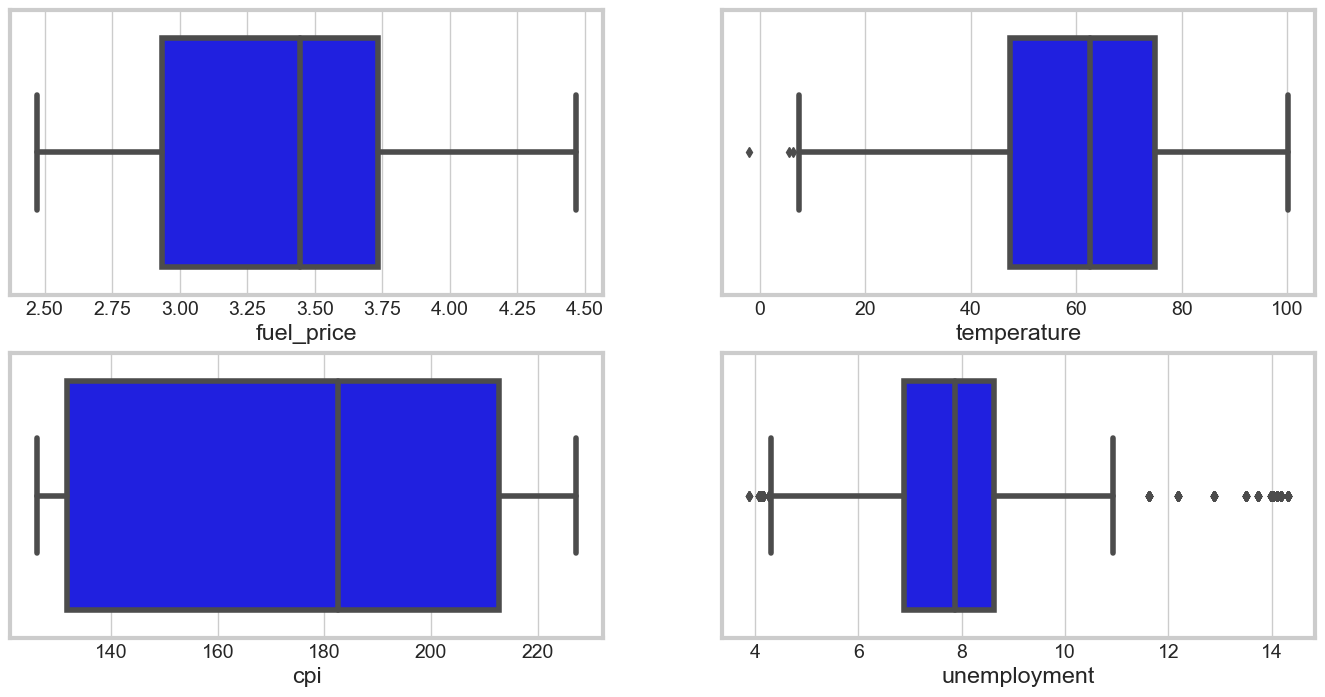

In [48]:
cols = ['fuel_price', 'temperature', 'cpi', 'unemployment']
plt.figure(figsize=(15,12))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data, x = col, color = 'blue')
plt.show()


**Conclusion**
- There are outliers in unemployement and temperature column.

# Data Correlation

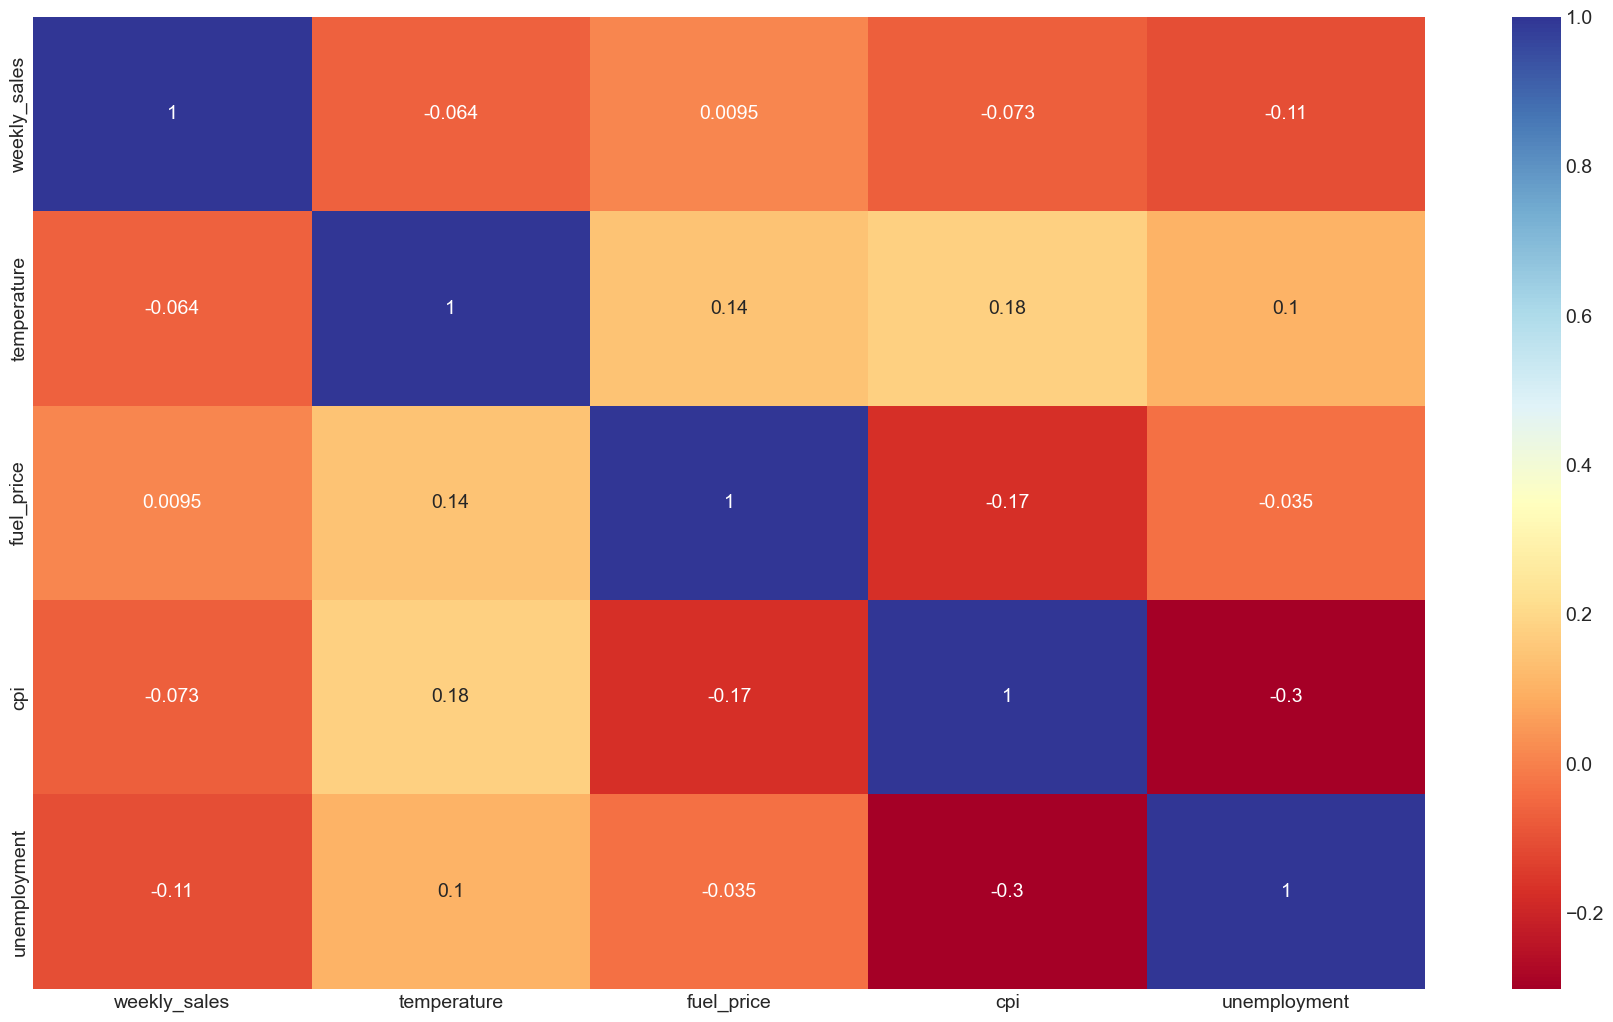

In [49]:
# Correlation Heatmap
plt.figure(figsize = (20, 12))
sns.heatmap(data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr(), annot = True, cmap='RdYlBu')
plt.show()

# Data Pre-processing

In [50]:
data

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,month,month_name,week,day_name,quarter,season
0,1,2010-02-05,"1,643,691",0,42,3,211,8,2010,2,February,5,Friday,1,Winter
1,1,2010-02-12,"1,641,957",1,39,3,211,8,2010,2,February,6,Friday,1,Winter
2,1,2010-02-19,"1,611,968",0,40,3,211,8,2010,2,February,7,Friday,1,Winter
3,1,2010-02-26,"1,409,728",0,47,3,211,8,2010,2,February,8,Friday,1,Winter
4,1,2010-03-05,"1,554,807",0,46,3,211,8,2010,3,March,9,Friday,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,174",0,65,4,192,9,2012,9,September,39,Friday,3,Summer
6431,45,2012-10-05,"733,455",0,65,4,192,9,2012,10,October,40,Friday,4,Autumn
6432,45,2012-10-12,"734,464",0,54,4,192,9,2012,10,October,41,Friday,4,Autumn
6433,45,2012-10-19,"718,126",0,56,4,192,9,2012,10,October,42,Friday,4,Autumn


## 1. Dropping Unnecessary Columns

In [51]:
data.drop(['date', 'year', 'quarter', 'month', 'day_name'], axis = 1, inplace = True)

In [52]:
data

,store,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,month_name,week,season
0,1,"1,643,691",0,42,3,211,8,February,5,Winter
1,1,"1,641,957",1,39,3,211,8,February,6,Winter
2,1,"1,611,968",0,40,3,211,8,February,7,Winter
3,1,"1,409,728",0,47,3,211,8,February,8,Winter
4,1,"1,554,807",0,46,3,211,8,March,9,Winter
...,...,...,...,...,...,...,...,...,...,...
6430,45,"713,174",0,65,4,192,9,September,39,Summer
6431,45,"733,455",0,65,4,192,9,October,40,Autumn
6432,45,"734,464",0,54,4,192,9,October,41,Autumn
6433,45,"718,126",0,56,4,192,9,October,42,Autumn


## 2. Removing Outliers

**A. Identify potential outliers**
- We have seen that there are outliers in Column unemployement and in temperature

**B. We will follow IQR approach**
- Interquartile Range (IQR): Data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where Q1 and Q3 are the first and third quartiles, respectively.

**C. Remove/Transform data points**
- We will proceed with deleting data points.

In [53]:
columns_for_outlier_removal = ['temperature', 'unemployment']

In [54]:
# Function to remove outliers using IQR and remove entire rows
def remove_outliers_rows_iqr(data, columns_for_outlier_removal, k=1.5):
    for col in columns_for_outlier_removal:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

In [55]:
data_cleaned = remove_outliers_rows_iqr(data, columns_for_outlier_removal)

0 temperature
1 fuel_price
2 cpi
3 unemployment


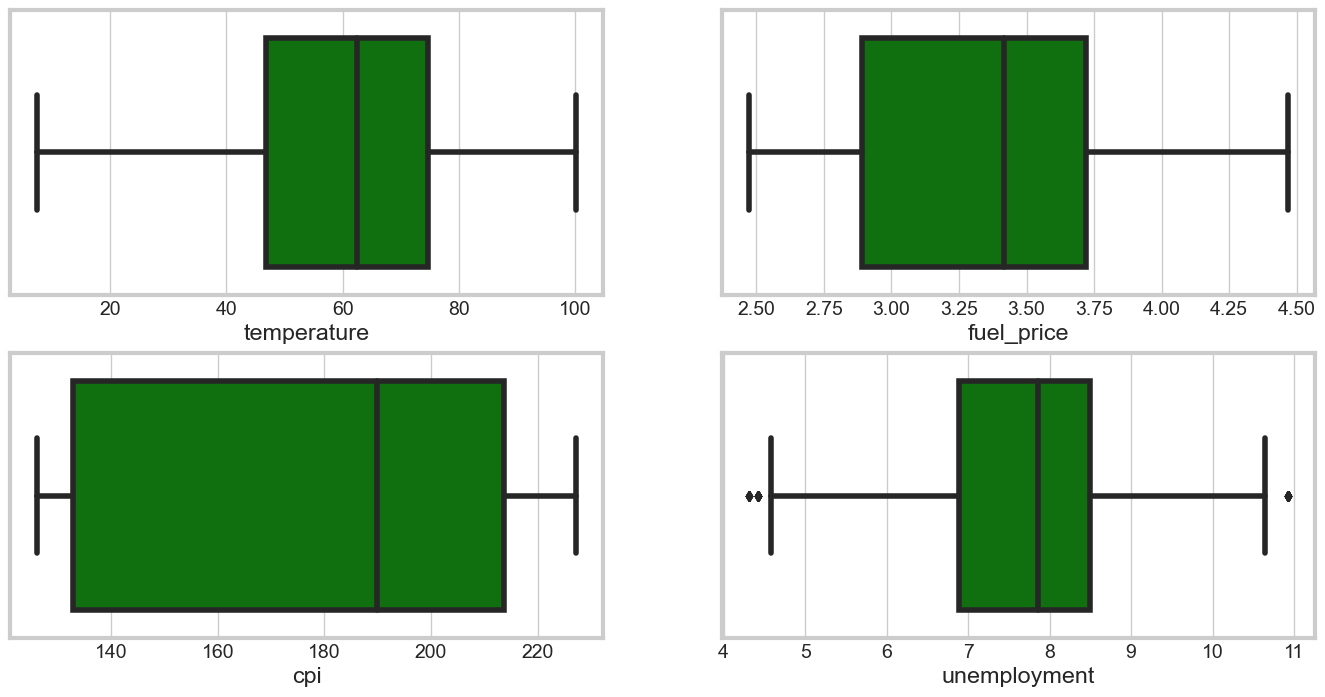

Number of data rows:  5951


In [56]:
cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']
plt.figure(figsize=(15,12))
for i, col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_cleaned, x = col, color = 'g')
plt.show()

print('Number of data rows: ', data_cleaned.shape[0])

### 3. Splitting The Data To Training And Testing Data

In [57]:
X = data_cleaned.drop('weekly_sales', axis = 1)
y = data_cleaned['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [58]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)

Shape of data      :  (5951, 9)
Shape of train data:  (4760, 9)
Shape of test data :  (1191, 9)


In [59]:
X_train.head()

,store,is_holiday,temperature,fuel_price,cpi,unemployment,month_name,week,season
4293,31,0,45,3,211,8,February,8,Winter
3558,25,0,76,3,215,7,July,27,Summer
4951,35,0,60,4,140,9,October,42,Autumn
3580,26,0,31,3,132,8,March,10,Winter
1555,11,0,88,3,225,7,June,26,Spring


In [60]:
y_train.head()

4293   1,344,354
3558     753,386
4951     811,328
3580     963,382
1555   1,297,029
Name: weekly_sales, dtype: float64

In [61]:
# Splitting the data into Numerical Features and Categorical Features
num_features = data_cleaned.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_cleaned.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['store', 'is_holiday', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'week']
Categorical Features: ['month_name', 'season']


In [62]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5951 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         5951 non-null   int64  
 1   weekly_sales  5951 non-null   float64
 2   is_holiday    5951 non-null   int64  
 3   temperature   5951 non-null   float64
 4   fuel_price    5951 non-null   float64
 5   cpi           5951 non-null   float64
 6   unemployment  5951 non-null   float64
 7   month_name    5951 non-null   object 
 8   week          5951 non-null   UInt32 
 9   season        5951 non-null   object 
dtypes: UInt32(1), float64(5), int64(2), object(2)
memory usage: 494.0+ KB


In [63]:
# We can see Store, is_holiday column and week column is wrongly classifed. So let's change the dataype. 
data_cleaned['store'] = data_cleaned['store'].astype('object')
data_cleaned['is_holiday'] = data_cleaned['is_holiday'].astype('object')
data_cleaned['week'] = data_cleaned['week'].astype('object')

In [64]:
# Now splitting the data into Numerical Features and Categorical Features
num_features = data_cleaned.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_cleaned.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['temperature', 'fuel_price', 'cpi', 'unemployment']
Categorical Features: ['store', 'is_holiday', 'month_name', 'week', 'season']


### 4. Data Transformation using Column transformer

In [65]:
# data transformation pipeline
trf = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
trf.fit(X_train,y_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'is_holiday', 'month_name', 'week',
                                  'season'])])

In [66]:
# Transform the training data
X_train_transformed = trf.transform(X_train)

# Transform the testing data
X_test_transformed = trf.transform(X_test)

In [67]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'Root Mean Square Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'R2_Square score: {round(r2_score(y, predict_data) * 100, 2)} % \n')

In [68]:
def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

In [69]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator

## 5. Model Creation

### 5.1 Linear Regression Model

In [70]:
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

#### Evaluation of training data.

In [71]:
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

Root Mean Square Error: 529898.57
R2_Square score: 14.55 % 



**Conclusion:**
- Since there are no linear correlations between variables and targets, The model seems to be not doing well in learning from the training dataset.

### 5.2 Decision Tree Regressor

In [72]:
DT = DecisionTreeRegressor()

# Fitting the training data
DT.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

#### Evaluation of training data.

In [73]:
model_evaluation(DT, 'Training', X_train_transformed, y_train)

Training Accuracy: 

Root Mean Square Error: 0.0
R2_Square score: 100.0 % 



**Conclusion:**

- The model has overfitting, so let's improve it by tuning the hyperparameters.

#### Tuning The Model

In [74]:
#Using grid search cv to tune the parameters.
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = hyperparameter_tunning(DT, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator

Best parameters: {'max_depth': 14, 'min_samples_split': 20} 

Best score: 0.9420201883671527


**Conclusion:**
- After tuning the hyperparameter of max_depth and min_samples_split, The model seems to have improved well in learning from the training dataset.

#### Cross validating the score

In [75]:
cross_validation_score(Best_Tree, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.95576996 0.94460764 0.94902318 0.94077236 0.95665056 0.94317969
 0.93514764 0.95353223 0.94742053 0.94839933] 

Mean of Scores: 94.75 % 

Standard Deviation of Scores: 0.006453652111288104


#### Testing the Model

In [76]:
model_evaluation(Best_Tree, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

Root Mean Square Error: 122673.55
R2_Square score: 95.34 % 



**Conclusion:**
- After testing the Decision Tree Regressor model, it became clear that it is the best model with an accuracy of 95.75 % compared to Linear Regression.

### 5.3 Random Forest Regressor


In [77]:
RF = RandomForestRegressor()

# Fitting the training data
RF.fit(X_train_transformed, y_train)

RandomForestRegressor()

#### Evaluation of training data.

In [78]:
model_evaluation(RF, 'Training', X_train_transformed, y_train)

Training Accuracy: 

Root Mean Square Error: 41563.74
R2_Square score: 99.47 % 



**Conclusion:**

- It seems like the model is overfitted.let's be sure of that by doing a cross-validation score.

In [79]:
cross_validation_score(RF, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.95980401 0.96262275 0.96227756 0.96230112 0.95857721 0.95120688
 0.95483192 0.95876249 0.95911056 0.95036409] 

Mean of Scores: 95.8 % 

Standard Deviation of Scores: 0.004219686333738628


**Conclusion:**

- After doing a cross-validation score, we see the model has trained very well.

#### Testing the Model


In [80]:
model_evaluation(RF, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

Root Mean Square Error: 112976.73
R2_Square score: 96.05 % 



**Conclusion:**

- After testing the Random Forest Regressor model, it became clear that it is the best model with an accuracy of 96.13% compared to the above algorithms we used (e.g. Linear Regression and Decision Tree Regressor).